# Mixing Score
The purpose of this notebook is to calculate the mixing score between any two cell populations in a sample.

In [3]:
import os
import seaborn
import pandas as pd

import ark.settings as settings
from ark.analysis.spatial_analysis import compute_cell_neighbors, compute_mixing_score, create_neighborhood_matrix, compute_cell_ratios
from ark.utils import spatial_analysis_utils, example_dataset
from tmi import misc_utils

## 0. Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook, as well as the data generated by segmentation and cell clustering.

In [ ]:
base_dir = '../data/example_dataset'

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting to `False` if you are running Notebooks 1,2,3 and 4 in succession. Set to `True` if you are just running Notebook 4.

In [ ]:
example_dataset.get_example_dataset(dataset="segment_image_data", save_dir = base_dir, overwrite_existing = True)

## 1. Define paths
* `cell_table_path`: the path to the cell table that contains columns for fov, cell label, and cell phenotype (generated from `3_Cluster_Cells.ipynb`)
* `segmentation_dir`: the path to the directory containing your segmentations (generated from 1_Segment_Image_Data.ipynb)
* `dist_mat_dir`: the path to directory containing the distance matrices for each FOV, if not previously generated by either [example_neighborhood_analysis_script.ipynb](./example_neighborhood_analysis_script.ipynb) or [example_pairwise_spatial_enrichment.ipynb](./example_pairwise_spatial_enrichment.ipynb), a new directory will be created below

In [ ]:
cell_table_path = os.path.join(base_dir, "segmentation/cell_table/cell_table_size_normalized_cell_labels.csv")
segmentation_dir = os.path.join(base_dir, "segmentation/deepcell_output")
dist_mat_dir = os.path.join(base_dir, "spatial_analysis/dist_mats")

# new directories
mixing_score_dir = os.path.join(base_dir, "mixing_score")
cell_neighbors_dir = os.path.join(mixing_score_dir, "cell_neighbors")

In [ ]:
# create output directory
if not os.path.exists(cell_neighbors_dir):
    os.makedirs(cell_neighbors_dir)

# create the dist_mat_output directory if it doesn't exist
if not os.path.exists(dist_mat_dir):
    os.makedirs(dist_mat_dir)
    spatial_analysis_utils.calc_dist_matrix(segmentation_dir, dist_mat_dir)
    
# create mixing directory
if not os.path.exists(mixing_score_dir):
    os.makedirs(mixing_score_dir)

### Read in data from the cell table

In [ ]:
all_data = pd.read_csv(cell_table_path)
all_fovs = all_data[settings.FOV_ID].unique()

### Define cell populations of interest and compute neighbors matrices
The neighbors matrix for each FOV will be saved as individual files in the the `cell_neighbors_dir`.

In [ ]:
pixel_radius = 100
compute_cell_neighbors(all_data, dist_mat_dir, cell_neighbors_dir, neighbors_radius=pixel_radius)

## 2. Examine ratio of cell populations

Looking at the cell populationrations will help with picking a cold threshold.
- `target_cell`: the infiltrating cell population
- `reference_cell`: the reference cell population
- `bins`: number of bins for the histogram, you may adjust this variable and rerun the below cells if necessary

In [ ]:
target_cell_list = ['Cancer']
reference_cell_list = ['T', 'B', 'Mono_Mac', 'NK', 'Granulocyte']
bins = 30

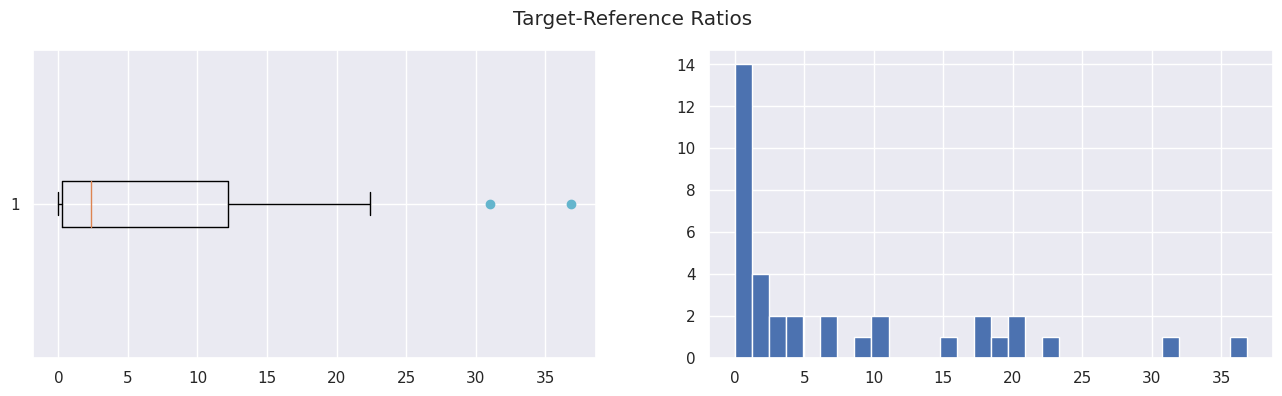

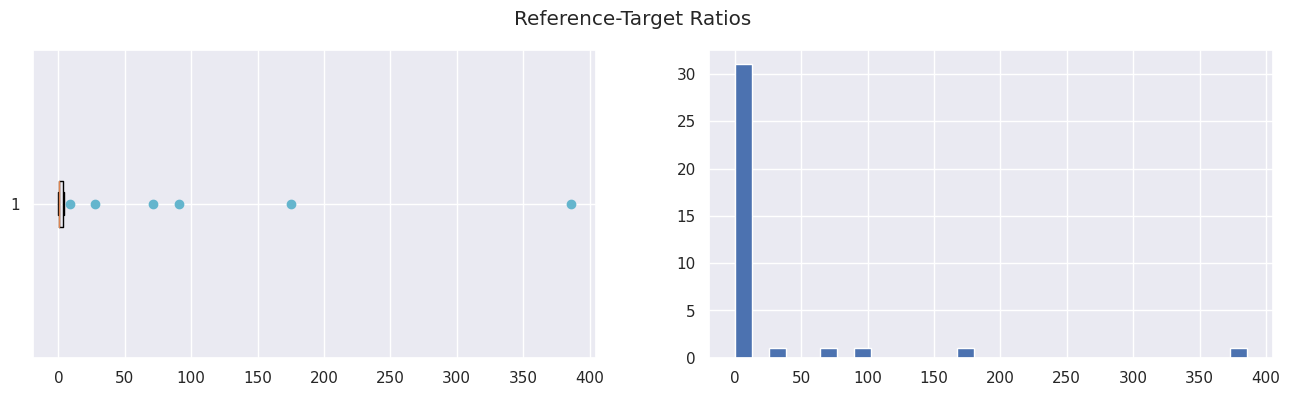

In [30]:
misc_utils.verify_in_list(provided_cell_populations=target_cell_list + reference_cell_list, 
                          cell_populations_in_fov=all_data[settings.CELL_TYPE].unique())

target_reference, reference_target = compute_cell_ratios(
    cell_neighbors_dir, target_cell_list, reference_cell_list, fov_list=all_fovs, bin_number=bins)

## 3. Compute mixing scores
This will compute the mixing score for each FOV and save the output in the `mixing_score_dir`. 
- `target_ratio`: the maximun ratio of target/reference cells in a FOV to not be classified as *cold*, cold samples will not be assigned a mixing score
- `reference_ratio`: the maximun ratio of reference/target cells in a FOV to not be classified as *cold*, cold samples will not be assigned a mixing score
- `cell_count_threshold`: the minimum number of cells in the target and reference populations found in a FOV to not be classified as *cold*, cold samples will not be assigned a mixing score

In [19]:
target_ratio = 5
reference_ratio = 5
cell_count_threshold = 250

<AxesSubplot:xlabel='mixing_score', ylabel='Count'>

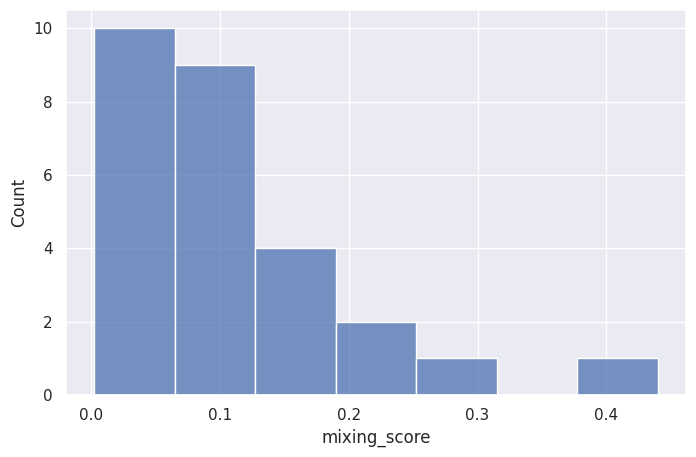

In [26]:
file_name = "Cancer_Immune-mixing_score.csv"

scores = []
for fov in all_fovs:
    fov_score = compute_mixing_score(cell_neighbors_dir, fov, target_cell_list, reference_cell_list, 
                                     target_ratio, reference_ratio, cell_count_threshold)
    scores.append(fov_score)
    
mixing_score_data = pd.DataFrame(list(zip(all_fovs, scores, target_reference, reference_target)), 
                                 columns =['fov', 'mixing_score', 'target_reference_ratio', 'reference_target_ratio'])
mixing_score_data.to_csv(os.path.join(mixing_score_dir, file_name), index=False)

seaborn.set(rc={'figure.figsize':(8,5)})
seaborn.histplot(mixing_score_data, x='mixing_score')